In [11]:
%matplotlib inline
%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import datetime
import os.path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from tramway.helper import (Analyses, infer, load_rwa, load_xyt, map_plot,
                            save_rwa, tessellate)
from tramway.inference import bayes_factors

In [13]:
# Choose input files and mesh parameters
# Delete the .rwa file if necessary to recalculate the results
input_folder = './input'

# trajectory_file = 'Brownien_P1.txt'
trajectory_file = 'Brownien_P4.txt'
# trajectory_file = 'VLP_WT_2_2.txt'

localization_error = 0
localization_error_BF = localization_error

cell_radii = [0.8, 0.4]  # .03]  # , .09, .27, .81]
location_counts = [1000, 500]  # 20, 80, 320, 1280]
B_thresholds = [10, 2]

trajectory_file = os.path.join(input_folder, trajectory_file)
rwa_file = os.path.splitext(trajectory_file)[0] + '.rwa'

In [14]:
# Load and tessellate the trajectory

if not os.path.isfile(rwa_file):
    # load the trajectories
    if 'Brownien' in trajectory_file:
        # time step (please check)
        dt = 1.0 / 65536
        # read the table
        xyt = load_xyt(trajectory_file, columns=['x', 'y', 'H'])
        # add missing columns
        xyt['n'] = np.ones(xyt.shape[0])
        xyt['t'] = np.arange(dt, (xyt.shape[0] + 1) * dt, dt)
    else:
        xyt = load_xyt(trajectory_file)

    analysis_tree = Analyses(xyt)
else:
    analysis_tree = load_rwa(rwa_file)

# tessellate
for radius in cell_radii:
    label = 'hexagon_r_{:.2f}'.format(radius)
    if label not in analysis_tree:
        cells = tessellate(analysis_tree, 'hexagon', ref_distance=radius,
                           min_location_count=0, label=label)
        save_rwa(rwa_file, analysis_tree, force=True)

for count in location_counts:
    label = 'kmeans_n_{:d}'.format(count)
    if label not in analysis_tree:
        cells = tessellate(analysis_tree, 'kmeans', ref_distance=0, avg_location_count=count,
                           knn=(round(.75 * count), round(1.25 * count)), prune=False, label=label)
        save_rwa(rwa_file, analysis_tree, force=True)

Bayes factors for mesh 'hexagon_r_0.40' with B threshold = 10


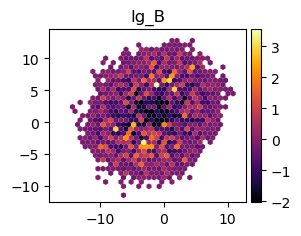

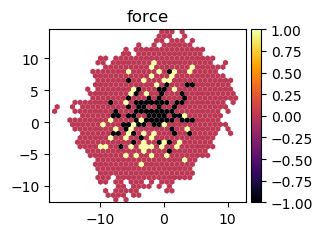

Bayes factors for mesh 'hexagon_r_0.40' with B threshold = 2


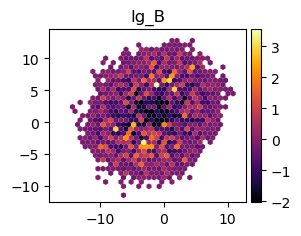

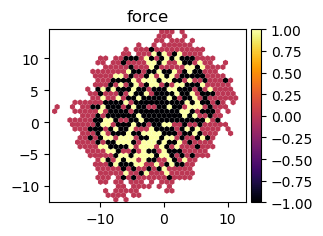

Bayes factors for mesh 'hexagon_r_0.80' with B threshold = 10


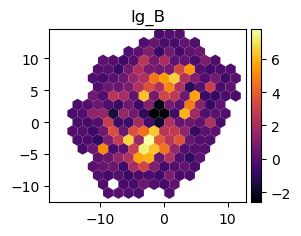

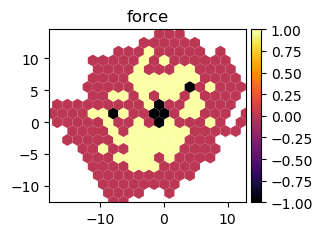

Bayes factors for mesh 'hexagon_r_0.80' with B threshold = 2


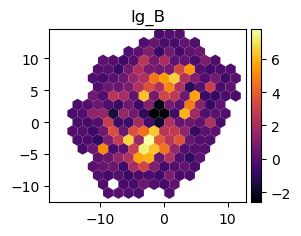

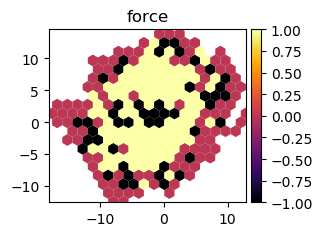

Bayes factors for mesh 'kmeans_n_1000' with B threshold = 10


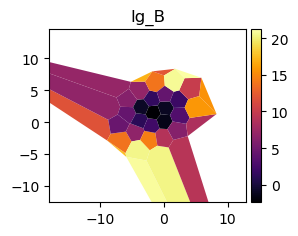

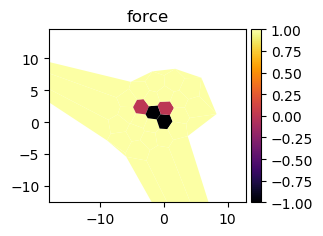

Bayes factors for mesh 'kmeans_n_1000' with B threshold = 2


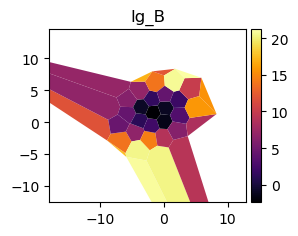

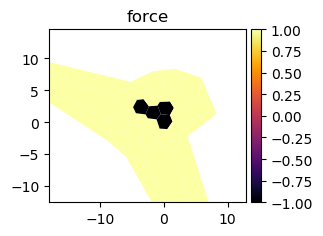

Bayes factors for mesh 'kmeans_n_500' with B threshold = 10


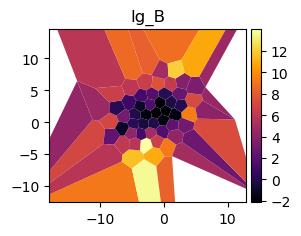

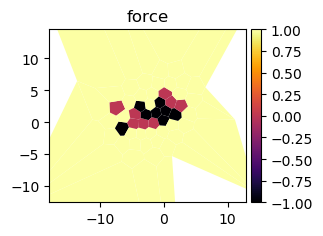

Bayes factors for mesh 'kmeans_n_500' with B threshold = 2


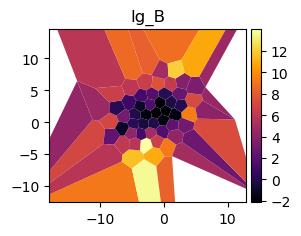

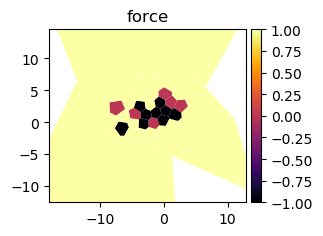

In [15]:
# Calculate and map bayes factors for the meshes above

snr_label = 'snr'
bayes_factor_label = 'bayes_factor'

analysis_tree = load_rwa(rwa_file)

for mesh in analysis_tree.labels:
    for B_threshold in B_thresholds:
        print("Bayes factors for mesh '{mesh}' with B threshold = {B_threshold}".format(
            mesh=mesh, B_threshold=B_threshold))

        # infer forces and diffusivity
        if snr_label not in analysis_tree[mesh]:
            infer(analysis_tree, 'snr', input_label=mesh, output_label=snr_label,
                  max_iter=50, localization_error=localization_error)
            save_rwa(rwa_file, analysis_tree, force=True)

        output_label = bayes_factor_label + str(B_threshold)
        if output_label not in analysis_tree[mesh][snr_label]:
            BF_results = infer(analysis_tree, 'bayes_factor',                            input_label=[mesh, snr_label],
                               output_label=output_label, localization_error=localization_error_BF, B_threshold=B_threshold)
            save_rwa(rwa_file, analysis_tree, force=True)
        else:
            BF_results = analysis_tree[mesh][snr_label][output_label].data

        lg_Bs = BF_results['lg_B']
        forces = BF_results['force']

        cells = analysis_tree[mesh].data
        map_plot(lg_Bs, cells=cells,
                 show=True, clip=False, colormap='inferno', alpha=1, linewidth=0.1, figsize=(6.85, 2.29), dpi=100, aspect='equal', colorbar='nice')

        map_plot(forces, cells=cells,
                 show=True, clip=False, colormap='inferno', alpha=1, linewidth=0.1, figsize=(6.85, 2.29), dpi=100, aspect='equal', colorbar='nice')